# LSTM-FCN Evaluation on New TEP Dataset

This notebook evaluates the trained LSTM-FCN model on the newly generated independent TEP dataset.

**Purpose**: Test model generalization on completely unseen data generated from `tep-sim`.

**Model**: LSTM-FCN (multiclass fault classification)

**Evaluation Dataset**: `data/new_multiclass_eval.csv` (generated by notebook 03)

## Configuration & Imports

In [1]:
import os
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../data')
MODEL_DIR = Path('../outputs/models')
METRICS_DIR = Path('../outputs/metrics')
FIGURES_DIR = Path('../outputs/figures')

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

QUICK_MODE = False
if (DATA_DIR / 'new_multiclass_eval_quick.csv').exists():
    if not (DATA_DIR / 'new_multiclass_eval.csv').exists():
        QUICK_MODE = True
    else:
        quick_mtime = (DATA_DIR / 'new_multiclass_eval_quick.csv').stat().st_mtime
        full_mtime = (DATA_DIR / 'new_multiclass_eval.csv').stat().st_mtime
        QUICK_MODE = quick_mtime > full_mtime

if os.environ.get('QUICK_MODE', '').lower() in ('true', '1', 'yes'):
    QUICK_MODE = True

FILE_SUFFIX = '_quick' if QUICK_MODE else ''

print('='*60)
print('LSTM-FCN Evaluation on New TEP Dataset')
if QUICK_MODE:
    print('QUICK MODE - Using limited test dataset')
print(f'Device: {device}')
print('='*60)

LSTM-FCN Evaluation on New TEP Dataset
Device: cuda


## Define Model Architecture

In [2]:
class LSTMFCN(nn.Module):
    """LSTM-FCN: Combines LSTM with 1D CNN for time series classification.
    
    Architecture matches v1/LSTM_FCN_final.ipynb:
    - Hierarchical conv filters (32→24→16) 
    - Dilation rates (1→2→4) for multi-scale feature extraction
    - SpatialDropout after first conv layer
    """
    def __init__(self, input_size, lstm_hidden, lstm_layers, dropout, num_classes):
        super().__init__()
        
        # LSTM branch
        self.lstm = nn.LSTM(input_size, lstm_hidden, lstm_layers,
                           batch_first=True, dropout=dropout if lstm_layers > 1 else 0)
        
        # FCN branch with hierarchical filters and dilation
        self.conv1 = nn.Conv1d(input_size, 32, kernel_size=7, padding='same', dilation=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.spatial_dropout = nn.Dropout2d(0.3)
        
        self.conv2 = nn.Conv1d(32, 24, kernel_size=5, padding='same', dilation=2)
        self.bn2 = nn.BatchNorm1d(24)
        
        self.conv3 = nn.Conv1d(24, 16, kernel_size=3, padding='same', dilation=4)
        self.bn3 = nn.BatchNorm1d(16)
        
        self.gap = nn.AdaptiveAvgPool1d(1)
        
        # Classifier head
        combined_dim = lstm_hidden + 16
        hidden_dim = max(32, num_classes * 2)
        self.fc1 = nn.Linear(combined_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        # LSTM branch: (batch, seq, features)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        
        # FCN branch: (batch, features, seq)
        x_cnn = x.permute(0, 2, 1)
        
        x_cnn = torch.relu(self.bn1(self.conv1(x_cnn)))
        x_cnn = self.spatial_dropout(x_cnn.unsqueeze(-1)).squeeze(-1)
        
        x_cnn = torch.relu(self.bn2(self.conv2(x_cnn)))
        x_cnn = torch.relu(self.bn3(self.conv3(x_cnn)))
        
        x_cnn = self.gap(x_cnn).squeeze(-1)
        
        # Combine and classify
        combined = torch.cat([lstm_out, x_cnn], dim=1)
        out = torch.relu(self.fc1(combined))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

print('Model class defined')

Model class defined


## Load Trained Model

In [3]:
print('\n[Step 1/5] Loading trained LSTM-FCN model...')

model_path = MODEL_DIR / 'lstm_fcn_final.pt'
model_data = torch.load(model_path, map_location=device, weights_only=False)

config = model_data['model_config']
features = model_data['features']
label_classes = model_data['label_encoder_classes']
scaler_mean = model_data['scaler_mean']
scaler_scale = model_data['scaler_scale']

num_classes = len(label_classes)
class_names = [str(int(c)) for c in label_classes]

model = LSTMFCN(
    input_size=len(features),
    lstm_hidden=config['lstm_hidden'],
    lstm_layers=config['lstm_layers'],
    dropout=config['dropout'],
    num_classes=num_classes
)
model.load_state_dict(model_data['model_state_dict'])
model.to(device)
model.eval()

print(f'Model loaded from {model_path}')
print(f'  Features: {len(features)}')
print(f'  Classes: {num_classes}')

orig_metrics_path = METRICS_DIR / 'lstm_fcn_metrics.json'
with open(orig_metrics_path) as f:
    orig_metrics = json.load(f)
print('Original metrics loaded for comparison')


[Step 1/5] Loading trained LSTM-FCN model...


Model loaded from ../outputs/models/lstm_fcn_final.pt
  Features: 52
  Classes: 18
Original metrics loaded for comparison


## Load New Evaluation Dataset

In [4]:
print('\n[Step 2/5] Loading new evaluation dataset...')
start_time = time.time()

eval_file = DATA_DIR / f'new_multiclass_eval{FILE_SUFFIX}.csv'
eval_data = pd.read_csv(eval_file)

print(f'Dataset loaded in {time.time() - start_time:.2f}s')
print(f'  File: {eval_file.name}')
print(f'  Shape: {eval_data.shape}')
print(f'  Unique runs: {eval_data.groupby(["faultNumber", "simulationRun"]).ngroups}')


[Step 2/5] Loading new evaluation dataset...


Dataset loaded in 14.25s
  File: new_multiclass_eval.csv
  Shape: (1968600, 57)
  Unique runs: 2700


## Create Sequence Dataset

In [5]:
class SimulationRunDataset(Dataset):
    def __init__(self, df, features, scaler_mean, scaler_scale, label_classes, sequence_length=10):
        self.sequence_length = sequence_length
        self.features = features
        self.label_classes = label_classes
        self.class_to_idx = {c: i for i, c in enumerate(label_classes)}
        
        self.sequences = []
        self.labels = []
        
        for (fault, run), group in df.groupby(['faultNumber', 'simulationRun']):
            group = group.sort_values('sample')
            X = group[features].values
            X = (X - scaler_mean) / scaler_scale
            
            for i in range(len(X) - sequence_length + 1):
                seq = X[i:i+sequence_length]
                self.sequences.append(seq)
                self.labels.append(self.class_to_idx[fault])
        
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx])

print('Dataset class defined')

Dataset class defined


In [6]:
print('\n[Step 3/5] Creating evaluation dataset...')
seq_len = config['sequence_length']

eval_dataset = SimulationRunDataset(
    eval_data, features, scaler_mean, scaler_scale, label_classes, seq_len
)
eval_loader = DataLoader(eval_dataset, batch_size=512, shuffle=False, num_workers=0)

print(f'Evaluation sequences: {len(eval_dataset):,}')


[Step 3/5] Creating evaluation dataset...


Evaluation sequences: 1,863,300


## Generate Predictions

In [7]:
print('\n[Step 4/5] Generating predictions...')
pred_start = time.time()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in eval_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

y_pred = np.array(all_preds)
y_eval = np.array(all_labels)

print(f'Predictions generated in {time.time() - pred_start:.2f}s')
print(f'  Predictions shape: {y_pred.shape}')


[Step 4/5] Generating predictions...


Predictions generated in 36.76s
  Predictions shape: (1863300,)


## Compute Evaluation Metrics

In [8]:
print('\n[Step 5/5] Computing evaluation metrics...')

accuracy = accuracy_score(y_eval, y_pred)
balanced_acc = balanced_accuracy_score(y_eval, y_pred)
f1_weighted = f1_score(y_eval, y_pred, average='weighted')
f1_macro = f1_score(y_eval, y_pred, average='macro')
precision_weighted = precision_score(y_eval, y_pred, average='weighted')
recall_weighted = recall_score(y_eval, y_pred, average='weighted')
f1_per_class = f1_score(y_eval, y_pred, average=None)
cm = confusion_matrix(y_eval, y_pred)

print('\n' + '='*60)
print('NEW EVALUATION DATASET RESULTS')
if QUICK_MODE:
    print('(Quick mode - limited samples per class)')
print('='*60)
print(f'Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)')
print(f'Balanced Accuracy: {balanced_acc:.4f}')
print(f'F1 (weighted):     {f1_weighted:.4f}')
print(f'F1 (macro):        {f1_macro:.4f}')
print('='*60)


[Step 5/5] Computing evaluation metrics...



NEW EVALUATION DATASET RESULTS
Accuracy:          0.9869 (98.69%)
Balanced Accuracy: 0.9881
F1 (weighted):     0.9871
F1 (macro):        0.9882


In [9]:
print('\nComparison with Original Test Set:')
print('-' * 50)
print(f'{"Metric":<20} {"Original":>12} {"New Eval":>12} {"Delta":>10}')
print('-' * 50)

comparisons = [
    ('Accuracy', orig_metrics['accuracy'], accuracy),
    ('Balanced Acc', orig_metrics['balanced_accuracy'], balanced_acc),
    ('F1 (weighted)', orig_metrics['f1_weighted'], f1_weighted),
    ('F1 (macro)', orig_metrics['f1_macro'], f1_macro),
]

for metric_name, orig_val, new_val in comparisons:
    delta = new_val - orig_val
    print(f'{metric_name:<20} {orig_val:>12.4f} {new_val:>12.4f} {delta:>+10.4f}')

print('-' * 50)


Comparison with Original Test Set:
--------------------------------------------------
Metric                   Original     New Eval      Delta
--------------------------------------------------
Accuracy                   0.9937       0.9869    -0.0068
Balanced Acc               0.9937       0.9881    -0.0056
F1 (weighted)              0.9937       0.9871    -0.0066
F1 (macro)                 0.9937       0.9882    -0.0056
--------------------------------------------------


In [10]:
print('\nPer-Class Classification Report:')
print(classification_report(y_eval, y_pred, target_names=class_names, digits=4))


Per-Class Classification Report:


              precision    recall  f1-score   support

           0     0.9808    0.8714    0.9229    114300
           1     1.0000    1.0000    1.0000    114300
           2     1.0000    1.0000    1.0000    114300
           4     1.0000    1.0000    1.0000    114300
           5     1.0000    1.0000    1.0000    114300
           6     1.0000    1.0000    1.0000     11700
           7     1.0000    1.0000    1.0000    114300
           8     1.0000    1.0000    1.0000    114300
          10     0.8405    0.9961    0.9117    114300
          11     1.0000    1.0000    1.0000    114300
          12     1.0000    1.0000    1.0000    114300
          13     0.9987    0.9961    0.9974    114300
          14     1.0000    1.0000    1.0000    114300
          16     0.9947    0.9921    0.9934    114300
          17     1.0000    0.9580    0.9786    114300
          18     0.9935    1.0000    0.9967     22800
          19     1.0000    0.9974    0.9987    114300
          20     1.0000    

## Visualizations

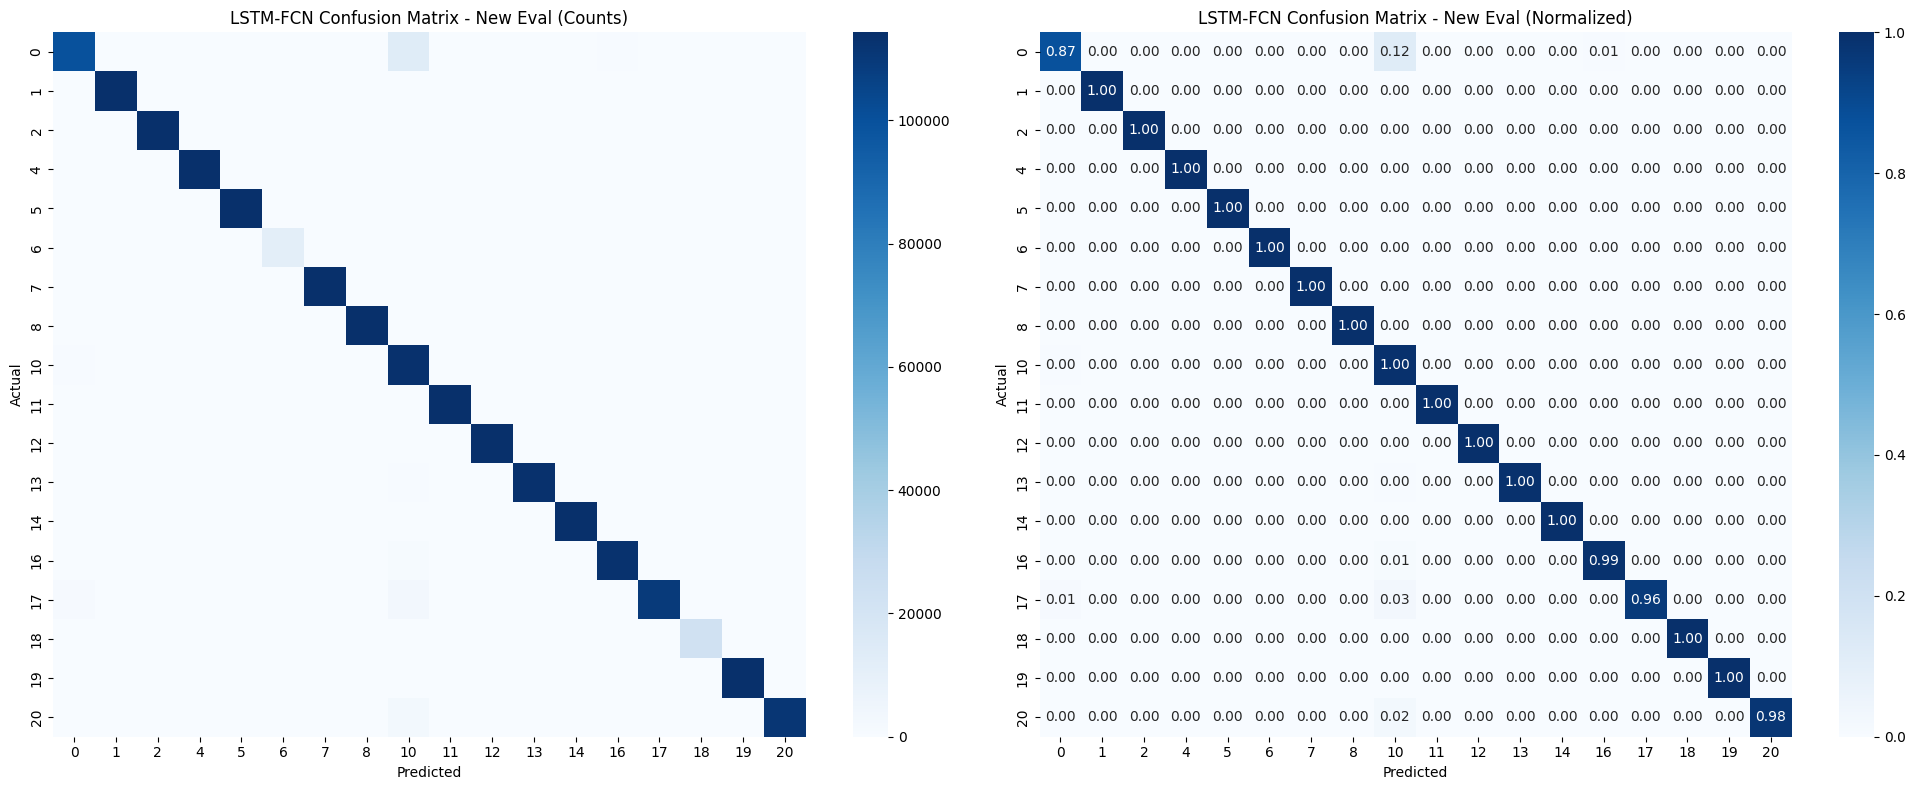

Saved to ../outputs/figures/lstm_fcn_new_eval_confusion_matrix.png


In [11]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('LSTM-FCN Confusion Matrix - New Eval (Counts)')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('LSTM-FCN Confusion Matrix - New Eval (Normalized)')

plt.tight_layout()
output_file = FIGURES_DIR / f'lstm_fcn_new_eval_confusion_matrix{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

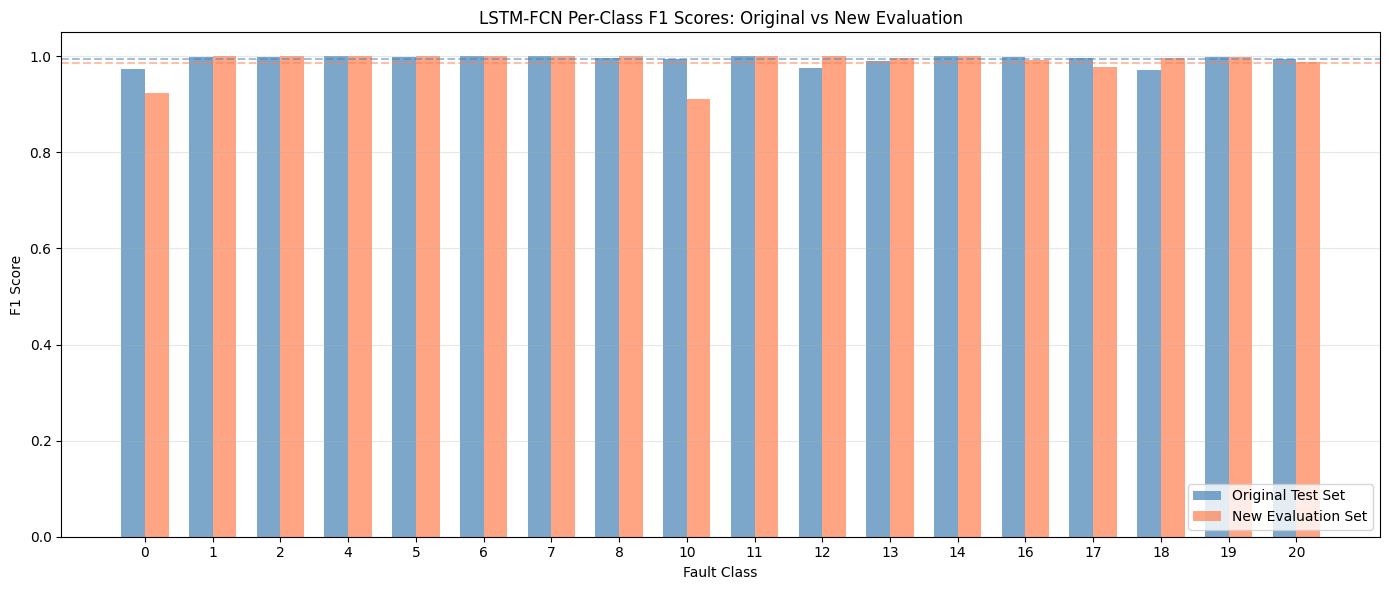

Saved to ../outputs/figures/lstm_fcn_new_eval_per_class_f1.png


In [12]:
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(class_names))
width = 0.35

orig_f1_per_class = [orig_metrics['per_class_f1'][c] for c in class_names]

bars1 = ax.bar(x - width/2, orig_f1_per_class, width, label='Original Test Set', color='steelblue', alpha=0.7)
bars2 = ax.bar(x + width/2, f1_per_class, width, label='New Evaluation Set', color='coral', alpha=0.7)

ax.axhline(y=orig_metrics['f1_weighted'], color='steelblue', linestyle='--', alpha=0.5)
ax.axhline(y=f1_weighted, color='coral', linestyle='--', alpha=0.5)

ax.set_xlabel('Fault Class')
ax.set_ylabel('F1 Score')
ax.set_title('LSTM-FCN Per-Class F1 Scores: Original vs New Evaluation')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
output_file = FIGURES_DIR / f'lstm_fcn_new_eval_per_class_f1{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

## Save Results

In [13]:
new_eval_metrics = {
    'model': 'LSTM-FCN',
    'dataset': f'new_multiclass_eval{FILE_SUFFIX}',
    'task': 'multiclass',
    'quick_mode': QUICK_MODE,
    'num_samples': len(y_eval),
    'num_classes': num_classes,
    'accuracy': float(accuracy),
    'balanced_accuracy': float(balanced_acc),
    'f1_weighted': float(f1_weighted),
    'f1_macro': float(f1_macro),
    'precision_weighted': float(precision_weighted),
    'recall_weighted': float(recall_weighted),
    'per_class_f1': {class_names[i]: float(f1_per_class[i]) for i in range(num_classes)},
    'comparison_with_original': {
        'accuracy_delta': float(accuracy - orig_metrics['accuracy']),
        'f1_weighted_delta': float(f1_weighted - orig_metrics['f1_weighted']),
        'original_accuracy': orig_metrics['accuracy'],
        'original_f1_weighted': orig_metrics['f1_weighted']
    }
}

output_file = METRICS_DIR / f'lstm_fcn_new_eval_metrics{FILE_SUFFIX}.json'
with open(output_file, 'w') as f:
    json.dump(new_eval_metrics, f, indent=2)
print(f'Saved metrics to {output_file}')

Saved metrics to ../outputs/metrics/lstm_fcn_new_eval_metrics.json


In [14]:
print('\n' + '='*60)
print('LSTM-FCN New Data Evaluation Complete!')
if QUICK_MODE:
    print('(Quick mode)')
print('='*60)
print(f'\nSummary:')
print(f'  Evaluation samples: {len(y_eval):,}')
print(f'  Accuracy: {accuracy:.4f} (original: {orig_metrics["accuracy"]:.4f}, delta: {accuracy - orig_metrics["accuracy"]:+.4f})')
print(f'  F1 (weighted): {f1_weighted:.4f} (original: {orig_metrics["f1_weighted"]:.4f}, delta: {f1_weighted - orig_metrics["f1_weighted"]:+.4f})')
print('='*60)


LSTM-FCN New Data Evaluation Complete!

Summary:
  Evaluation samples: 1,863,300
  Accuracy: 0.9869 (original: 0.9937, delta: -0.0068)
  F1 (weighted): 0.9871 (original: 0.9937, delta: -0.0066)
